# Unit Commercial Forest Modelling

# Silviculture Cost Model

Generates **annual silviculture costs** for a plantation under configurable scenario settings:

## Scenarios:
- **Rotation** $R \in \{6,7,\dots,12\}$ years
- **Thinning** $\in \{\text{"yes"},\text{"no"}\}$
    - If `thinning = "no"`:
        - Silviculture runs at **full intensity** in all years t.
    - If `thinning = "yes"`:
        - Thinning is implemented as **cost-intensity discounts** on *maintenance* (Discount timing is rotation-dependent):
            - **First thinning discount:** If $R \ge 6$: apply discount starting in **year 4**
            - **Second thinning discount:** If $R \ge 9$: apply an additional discount starting in **year 7**.
yutsid thmodule.)

--Quantity Quantity scenario
- *** \( \in \{\text{"min"},\text{"mid"},\text{"max"}\} \)

All physical requirements (e.g., man-days/ha, herbicide L/ha, fertilizer kg/ha, etc.) are parameterized as **ranges**:
- \(\text{qty}_{\min}\), \(\text{qty}_{\max}\)

Scenario mapping:
- `min`  \(\rightarrow \text{qty} = \text{qty}_{\min}\)
- `max`  \(\r
(\text{qty}_{\min}+\text{qty}_{\max})\)

---

### 2.3 Wage / input price scenario
- **wage_scenario** \( \in \{\text{"min"},\text{"mid"},\text{"max"}\} \)

All unit costs (daily wages and input prices) are parameterized as:
- \(\text{price}_{\min}\), \(\text{price}_{\max}\)

Scenario mapping:
- `min`  \(\rightarrow \text{price} = \text{price}_{\min}\)
- `max`  \(\rightarrow \text{price} = \text{price}_{\max}\)
- `mid`  \(\rightarrow \text{price} = 0.5(\text{price}_{\min}+\text{price}_{\max})\)

---

### 2.4 Labour mix
- **labour_mix** \( \in \{\text{"unskilled"},\text{"semi"}\} \)

This toggle controls **who performs the basic work** (and therefore which daily wage rate is applied):
- `unskilled`: cato a specialized labour category elsewhere in the cost library.

---

## 3) Labour Allowance (Applies to ALL Labour)

A universal **crew day allowance** is applied per worker-day:

- Parameter name: **N_CREW_DAYALLOW**
- Definition: **2 meals + single-room rent in a remote area**
- Allowance price range (UGX / worker-day):
  - \(\text{allow}_{\min} = 8{,}000\)
  - \(\text{allow}_{\max} = 20{,}000\)
  - `mid` is defined as \(0.5(\text{allow}_{\min}+\text{allow}_{\max})\)

This allowance is included as a separate sub-cost line (or embedded consistently in labour cost, but never double-counted).

---

## 4) Annual Cost Composition

For each year \( t \), total silviculture cost is computed as the sum of **sub-cost items**:
- Labour cost (wage-driven) + labour allowance
- Consumable inputs (chemical/fertilizer/etc.) using quantity × unit price
- Any additional fixed/variable silviculture items included in the library

If `thinning="yes"`, year-specific **intensity multipliers** modify:
- labour quantities (man-days)
- input quantities (application volumes)
from the relevant thinning start years onward.

---

## 5) Required Visual Outputs

### 5.1 Waterfall per year (with sub-cost legend)
For each year \( t \):
- Produce a **stacked waterfall** chart showing each sub-cost contribution.
- Include a **sub-cost legend** clearly listing all cost components.

### 5.2 Cashflow bars + cumulative curve
Across years \( t=1,\dots,R \):
- Plot annual **cashflow bars** (costs as negative cashflows).
- Overlay a **cumulative cashflow curve** (running total) to show total cost-to-date over the rotation.

---


Total cost per year (UGX/ha):
year
1    5381600.0
2     443600.0
3     443600.0
4     221800.0
5     221800.0
6     221800.0
7     221800.0
8     221800.0
Name: cost, dtype: float64


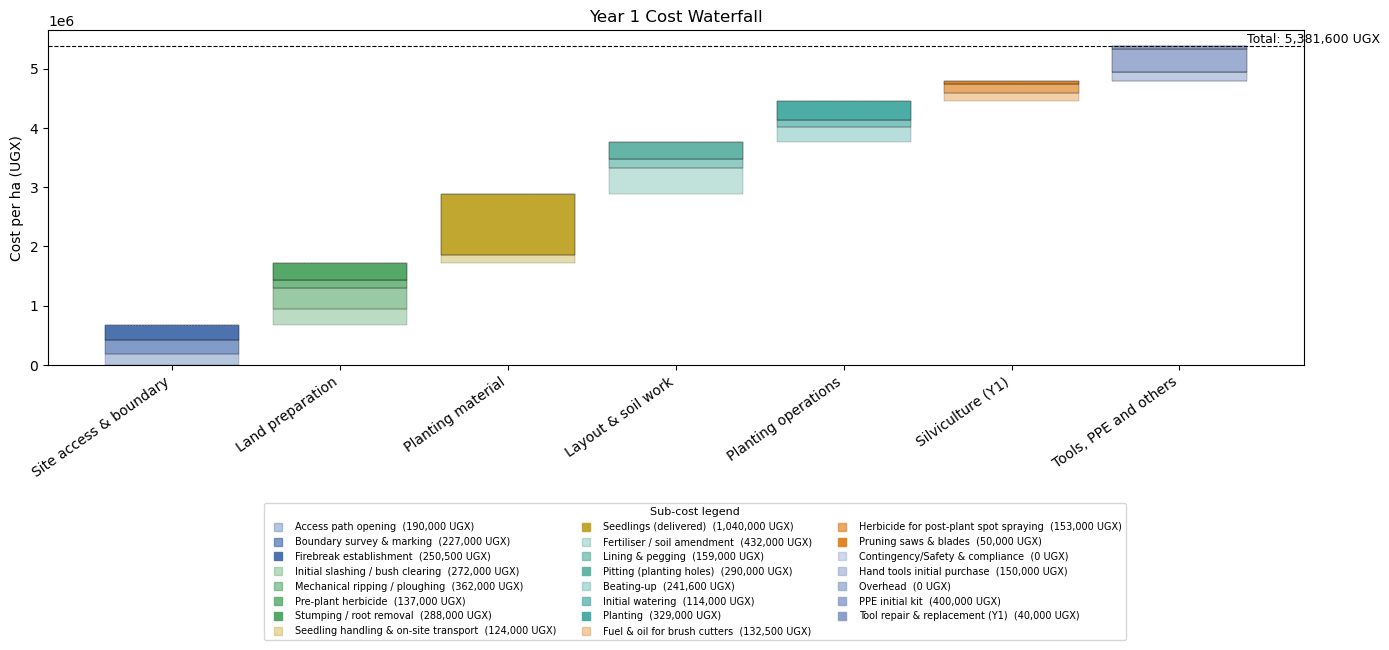

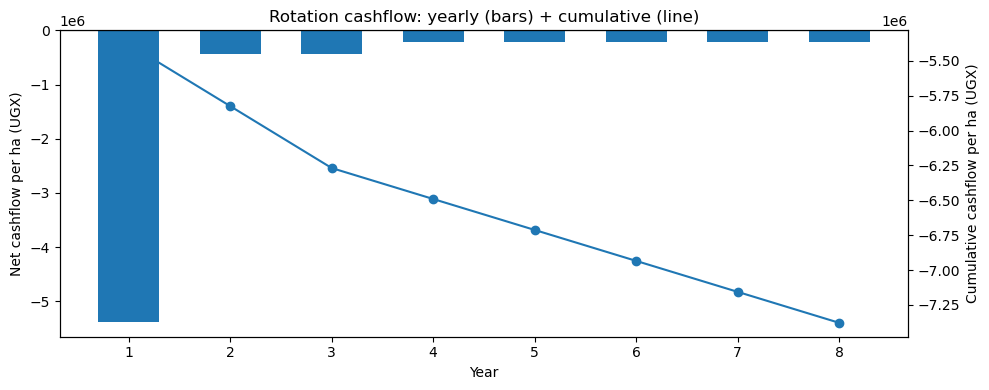

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# ================================================================
# 1. LABOUR CATEGORIES (daily wage library)
# ================================================================
labour_categories = pd.DataFrame([
    {"labour_code": "L_UNSKILLED",    "desc": "Casual field worker",
     "wage_min": 5_000,  "wage_max": 12_000},
    {"labour_code": "L_SKILLED", "desc": "Experienced field worker",
     "wage_min": 10_000,  "wage_max": 20_000},
    {"labour_code": "L_OPERATOR",     "desc": "Equipment operator",
     "wage_min": 10_000,  "wage_max": 30_000},
    {"labour_code": "L_SUPERVISOR",   "desc": "Field supervisor / foreman",
     "wage_min": 15_000, "wage_max": 60_000},
    {"labour_code": "L_SURVEYOR",     "desc": "Professional surveyor / forester",
     "wage_min": 30_000, "wage_max": 90_000},
])


# ================================================================
# 2. NON-LABOUR INPUTS (price library)
# ================================================================
non_labour_items = pd.DataFrame([
    {"item_code": "N_SEEDLING",         "desc": "Seedling delivered", "unit": "seedling",
     "price_min": 300,    "price_max": 800},
    {"item_code": "N_HERBICIDE_L",      "desc": "Herbicide concentrate","unit": "litre",
     "price_min": 15_000, "price_max": 30_000},
    {"item_code": "N_FERTILISER_KG",    "desc": "Fertiliser (NPK)",    "unit": "kg",
     "price_min": 3_000,  "price_max": 5_000},
    {"item_code": "N_DIESEL_L",         "desc": "Diesel fuel",         "unit": "litre",
     "price_min": 4_300,  "price_max": 5_500},
    {"item_code": "N_PEG",              "desc": "Boundary peg",        "unit": "peg",
     "price_min": 50,       "price_max": 150},
    {"item_code": "N_MARKING_PAINT_L",  "desc": "Marking paint",       "unit": "litre",
     "price_min": 15_000,       "price_max": 40_000},
    {"item_code": "N_HAND_TOOL_KIT",    "desc": "Hand tool kit",       "unit": "kit",
     "price_min": 50_000,       "price_max": 100_000},
    {"item_code": "N_PPE_SET",          "desc": "PPE set",             "unit": "set",
     "price_min": 50_000,       "price_max": 100_000},
    {"item_code": "N_TRUCK_TRIP_LOCAL", "desc": "Truck trip (local)",  "unit": "trip",
     "price_min": 60_000,  "price_max": 120_000},
    {"item_code": "N_PICKUP_TRIP_LOCAL","desc": "Pickup trip",         "unit": "trip",
     "price_min": 40_000,  "price_max": 80_000},
    {"item_code": "N_MECH_RIP_HA",      "desc": "Mechanical ripping",  "unit": "ha",
     "price_min": 200_000, "price_max": 330_000},
    {"item_code": "N_WATER_M3",         "desc": "Water delivered",     "unit": "m3",
     "price_min": 10_000,       "price_max": 25_000},
    {"item_code": "N_CREW_DAYALLOW",    "desc": "Meals + room per worker-day",
     "unit": "worker_day",
     "price_min": 8_000,  "price_max": 20_000},
])


# ================================================================
# 3. Scenario quantity selector
# ================================================================
def select_qty(val, scenario: str):
    """
    val = scalar OR (min, max)
    scenario ∈ {"min", "mid", "max"}
    - if scalar: returned as-is for any scenario
    - if tuple/list: (q_min, q_max), mid = 0.5*(q_min + q_max)
    """
    if not isinstance(val, (tuple, list)):
        return val

    if len(val) != 2:
        raise ValueError("Quantity tuples must be length 2: (min, max).")

    q_min, q_max = val

    if scenario == "min":
        return q_min
    elif scenario == "max":
        return q_max
    else:
        return 0.5 * (q_min + q_max)


# ================================================================
# 4. Intensity scaling after thinning
# ================================================================
def get_intensity_scale(year,
                        rotation_year,
                        section,
                        thinning_on="yes",
                        scale_after_thin1=0.5,
                        scale_after_thin2=0.3):
    """
    Returns multiplicative factor for quantities given:

      - If thinning_on == "no": scale = 1.0 for all years.
      - If thinning_on == "yes":
          * thinning logic as:
              - if rotation_year >= 6 and year >= 4:
                     scale_after_thin1
              - if rotation_year >= 9 and year >= 7:
                     scale_after_thin2
        Scaling applies ONLY to maintenance-type sections:
    """
    if thinning_on != "yes":
        return 1.0

    scaled_sections = (
        "Silviculture",
        "Labour welfare & ops",
        "Tools, PPE and others",
    )
    if not any(section.startswith(s) for s in scaled_sections):
        return 1.0

    # First thinning at year 4 (if R >= 6)
    if rotation_year >= 6 and year >= 4:
        # Second thinning at year 7 (if R >= 9)
        if rotation_year >= 9 and year >= 7:
            return scale_after_thin2
        else:
            return scale_after_thin1

    return 1.0

# ================================================================
# 5. Cost Engine with scenario toggles
# ================================================================
def compute_costs(operation_recipes,
                  labour_categories,
                  non_labour_items,
                  rotation_year,
                  qty_scenario="mid",
                  wage_scenario="mid",
                  labour_mix="unskilled",
                  thinning_on="yes",
                  semi_efficiency_factor=0.7,
                  scale_after_thin1=0.5,
                  scale_after_thin2=0.3):

    if not (6 <= rotation_year <= 12):
        raise ValueError("rotation_year must be between 6 and 12.")

    # Wage dictionaries
    w_min = dict(zip(labour_categories.labour_code,
                     labour_categories.wage_min))
    w_max = dict(zip(labour_categories.labour_code,
                     labour_categories.wage_max))
    w_mid = {k: 0.5 * (w_min[k] + w_max[k]) for k in w_min}

    # Price dictionaries
    p_min = dict(zip(non_labour_items.item_code,
                     non_labour_items.price_min))
    p_max = dict(zip(non_labour_items.item_code,
                     non_labour_items.price_max))
    p_mid = {k: 0.5 * (p_min[k] + p_max[k]) for k in p_min}

    wage  = {"min": w_min, "mid": w_mid, "max": w_max}[wage_scenario]
    price = {"min": p_min, "mid": p_mid, "max": p_max}[wage_scenario]

    allow_price = price["N_CREW_DAYALLOW"]  # meals + room per worker-day

    rows = []

    for op in operation_recipes:
        year    = op["year"]
        section = op["section"]

        if year > rotation_year:
            continue

        scale = get_intensity_scale(year,
                                    rotation_year,
                                    section,
                                    thinning_on=thinning_on,
                                    scale_after_thin1=scale_after_thin1,
                                    scale_after_thin2=scale_after_thin2)

        row = {
            "year":     year,
            "section":  section,
            "sub_item": op["sub_item"],
        }

        lab = op.get("labour_mandays") or {}
        nl  = op.get("non_labour_items") or {}

        labour_cost = 0.0
        labour_days_for_allowance = 0.0
        
        # --- labour cost + effective days (strict labour-mix selection) ---
        for code, q in lab.items():
        
            # labour_mix == "unskilled" → ignore semi-skilled
            if labour_mix == "unskilled" and code == "L_SEMI_SKILLED":
                continue
        
            # labour_mix == "semi" → ignore unskilled
            if labour_mix == "semi" and code == "L_UNSKILLED":
                continue
        
            q_eff = select_qty(q, qty_scenario) * scale
        
            labour_cost += q_eff * wage[code]
            labour_days_for_allowance += q_eff   # allowance applies to all used labour

        # --- non-labour cost from recipes ---
        nonlab_cost = 0.0
        for item, q in nl.items():
            q_base = select_qty(q, qty_scenario) * scale
            if item not in price:
                raise KeyError(f"Non-labour item '{item}' not found in price table.")
            nonlab_cost += q_base * price[item]

        # --- crew meals + room allowance (applied to all labour) ---
        allow_cost = labour_days_for_allowance * allow_price

        total_cost = labour_cost + nonlab_cost + allow_cost

        row["labour_cost"] = labour_cost
        row["nonlab_cost"] = nonlab_cost
        row["allow_cost"]  = allow_cost
        row["cost"]        = total_cost
        row["labour_days"] = labour_days_for_allowance

        rows.append(row)

    df = pd.DataFrame(rows)
    return df


# ================================================================
# 6. Operation recipes builder (Year 1 + generic maintenance)
#    Quantities are (min, max) only
# ================================================================
def build_operation_recipes(rotation_year):
    """
    Build operation recipes up to rotation_year.
    Year 1: establishment.
    Years 2-R: generic maintenance pattern (scaled appropriately)
    """
    if not (6 <= rotation_year <= 12):
        raise ValueError("rotation_year must be between 6 and 12.")

    ops = []

    # ---------- YEAR 1 ----------
    year1_ops = [

        # 1) Site access & boundary
        {
            "year": 1,
            "section": "Site access & boundary",
            "sub_item": "Boundary survey & marking",
            "labour_mandays": {
                "L_SURVEYOR": (0.0, 1.0),
                "L_UNSKILLED": (0.0, 1.5),
            },
            "non_labour_items": {
                "N_PEG": (0, 60),
                "N_MARKING_PAINT_L": (0.0, 0.5),
                "N_PICKUP_TRIP_LOCAL": (0.0, 0.5),
            },
        },
        {
            "year": 1,
            "section": "Site access & boundary",
            "sub_item": "Access path opening",
            "labour_mandays": {
                "L_UNSKILLED": (0.0, 2.5),
                "L_SUPERVISOR": (0.0, 0.25),
            },
            "non_labour_items": {
                "N_TRUCK_TRIP_LOCAL": (0.0, 0.75),
            },
        },
        {
            "year": 1,
            "section": "Site access & boundary",
            "sub_item": "Firebreak establishment",
            "labour_mandays": {
                "L_UNSKILLED": (0.0, 3.5),
                "L_SUPERVISOR": (0.0, 0.5),
            },
            "non_labour_items": {
                "N_PICKUP_TRIP_LOCAL": (0.0, 0.75),
                "N_DIESEL_L": (0, 7),
            },
        },

        # 2) Land preparation
        {
            "year": 1,
            "section": "Land preparation",
            "sub_item": "Initial slashing / bush clearing",
            "labour_mandays": {
                "L_UNSKILLED": (2.0, 4.0),
                "L_SUPERVISOR": (0.0, 0.5),
            },
            "non_labour_items": {
                "N_PICKUP_TRIP_LOCAL": (0.0, 0.75),
                "N_DIESEL_L": (0, 8),
            },
        },
        {
            "year": 1,
            "section": "Land preparation",
            "sub_item": "Stumping / root removal",
            "labour_mandays": {
                "L_UNSKILLED": (0.0, 4.0),
                "L_SUPERVISOR": (0.0, 0.5),
            },
            "non_labour_items": {
                "N_TRUCK_TRIP_LOCAL": (0.0, 1),
            },
        },
        {
            "year": 1,
            "section": "Land preparation",
            "sub_item": "Pre-plant herbicide",
            "labour_mandays": {
                "L_UNSKILLED": (0.0, 1),
                "L_SUPERVISOR": (0.0, 0.25),
            },
            "non_labour_items": {
                "N_HERBICIDE_L": (0.0, 1.5),
                "N_PICKUP_TRIP_LOCAL": (0.0, 0.5),
            },
        },
        {
            "year": 1,
            "section": "Land preparation",
            "sub_item": "Mechanical ripping / ploughing",
            "labour_mandays": {
                "L_UNSKILLED": (0.0, 1),
            },
            "non_labour_items": {
                "N_MECH_RIP_HA": (0.0, 1.0),
            },
        },

        # 3) Planting material
        {
            "year": 1,
            "section": "Planting material",
            "sub_item": "Seedlings (delivered)",
            "labour_mandays": {},
            "non_labour_items": {
                "N_SEEDLING": (1000, 1300),
            },
        },
        {
            "year": 1,
            "section": "Planting material",
            "sub_item": "Seedling handling & on-site transport",
            "labour_mandays": {
                "L_UNSKILLED": (0.5, 2.0),
            },
            "non_labour_items": {
                "N_PICKUP_TRIP_LOCAL": (0.25, 0.75),
            },
        },

        # 4) Layout & soil work
        {
            "year": 1,
            "section": "Layout & soil work",
            "sub_item": "Lining & pegging",
            "labour_mandays": {
                "L_UNSKILLED": (1.0, 2.5),
                "L_SUPERVISOR": (0.0, 0.5),
            },
            "non_labour_items": {
                "N_PEG": (0, 260),
            },
        },
        {
            "year": 1,
            "section": "Layout & soil work",
            "sub_item": "Pitting (planting holes)",
            "labour_mandays": {
                "L_UNSKILLED": (2.0, 5.0),
                "L_SUPERVISOR": (0.0, 0.5),
            },
            "non_labour_items": {
                "N_TRUCK_TRIP_LOCAL": (0.25, 0.75),
            },
        },
        {
            "year": 1,
            "section": "Layout & soil work",
            "sub_item": "Fertiliser / soil amendment",
            "labour_mandays": {
                "L_UNSKILLED": (0.0, 1),
            },
            "non_labour_items": {
                "N_FERTILISER_KG": (0, 80),
            },
        },

        # 5) Planting operations
        {
            "year": 1,
            "section": "Planting operations",
            "sub_item": "Planting",
            "labour_mandays": {
                "L_UNSKILLED": (2.0, 4.0),
                "L_SUPERVISOR": (0.25, 1),
            },
            "non_labour_items": {
                "N_TRUCK_TRIP_LOCAL": (0.2, 0.8),
                "N_WATER_M3": (0.0, 1.0),   # some sites may plant into moist soil
            },
        },
        {
            "year": 1,
            "section": "Planting operations",
            "sub_item": "Initial watering",
            "labour_mandays": {
                "L_UNSKILLED": (0.0, 2.0),
            },
            "non_labour_items": {
                "N_WATER_M3": (0.0, 2.0),
            },
        },
        {
            "year": 1,
            "section": "Planting operations",
            "sub_item": "Beating-up",
            "labour_mandays": {
                "L_UNSKILLED": (0.0, 2.0),
            },
            "non_labour_items": {
                # 0–20% beating-up on 1111 planted
                "N_SEEDLING": (0, int(0.2 * 1111)),
            },
        },

        # 6) Silviculture (Y1)
        {
            "year": 1,
            "section": "Silviculture (Y1)",
            "sub_item": "Herbicide for post-plant spot spraying",
            "labour_mandays": {
                "L_UNSKILLED": (0.0, 1.5),
                "L_SUPERVISOR": (0.0, 0.25),
            },
            "non_labour_items": {
                "N_HERBICIDE_L": (0.0, 1.5),
                "N_PICKUP_TRIP_LOCAL": (0.0, 0.5),
            },
        },
        {
            "year": 1,
            "section": "Silviculture (Y1)",
            "sub_item": "Fuel & oil for brush cutters",
            "labour_mandays": {
                "L_OPERATOR": (0.0, 1.0),
            },
            "non_labour_items": {
                "N_DIESEL_L": (0, 15),
            },
        },
        {
            "year": 1,
            "section": "Silviculture (Y1)",
            "sub_item": "Pruning saws & blades",
            "labour_mandays": {},
            "non_labour_items": {
                "N_HAND_TOOL_KIT": (0.0, 0.5),
            },
        },

        # 7) Tools, PPE and others
        {
            "year": 1,
            "section": "Tools, PPE and others",
            "sub_item": "PPE initial kit",
            "labour_mandays": {},
            "non_labour_items": {
                "N_PPE_SET": (0.0, 4.0),
            },
        },
        {
            "year": 1,
            "section": "Tools, PPE and others",
            "sub_item": "Hand tools initial purchase",
            "labour_mandays": {},
            "non_labour_items": {
                "N_HAND_TOOL_KIT": (0.0, 1.5),
            },
        },
        {
            "year": 1,
            "section": "Tools, PPE and others",
            "sub_item": "Tool repair & replacement (Y1)",
            "labour_mandays": {},
            "non_labour_items": {
                "N_HAND_TOOL_KIT": (0.0, 0.4),
            },
        },
        {
            "year": 1,
            "section": "Tools, PPE and others",
            "sub_item": "Contingency/Safety & compliance",
            "labour_mandays": {},
            "non_labour_items": {},
        },
        {
            "year": 1,
            "section": "Tools, PPE and others",
            "sub_item": "Overhead",
            "labour_mandays": {},
            "non_labour_items": {},
        },
    ]

    ops.extend(year1_ops)

    # ---------- Years 2..R: generic maintenance pattern (full intensity) ----------
    for y in range(2, rotation_year + 1):
        ops += [
            {
                "year": y,
                "section": f"Silviculture (Y{y})",
                "sub_item": "Herbicide & chemicals",
                "labour_mandays": {
                    "L_UNSKILLED": (0.0, 1.3),
                    "L_SUPERVISOR": (0.0, 0.2),
                },
                "non_labour_items": {
                    "N_HERBICIDE_L": (0.0, 1.3),
                    "N_TRUCK_TRIP_LOCAL": (0.0, 0.4),
                },
            },
            {
                "year": y,
                "section": f"Silviculture (Y{y})",
                "sub_item": "Fuel & oil for equipment",
                "labour_mandays": {
                    "L_OPERATOR": (0.0, 0.9),
                },
                "non_labour_items": {
                    "N_DIESEL_L": (0, 12),
                },
            },
            {
                "year": y,
                "section": f"Silviculture (Y{y})",
                "sub_item": "Pruning saws & blades",
                "labour_mandays": {},
                "non_labour_items": {
                    "N_HAND_TOOL_KIT": (0.0, 0.2),
                },
            },
            {
                "year": y,
                "section": "Labour welfare & ops",
                "sub_item": f"Labour transport (Y{y})",
                "labour_mandays": {},
                "non_labour_items": {
                    "N_TRUCK_TRIP_LOCAL": (0.0, 0.9),
                },
            },
            {
                "year": y,
                "section": "Tools, PPE and others",
                "sub_item": f"Tools & PPE replacement (Y{y})",
                "labour_mandays": {},
                "non_labour_items": {
                    "N_HAND_TOOL_KIT": (0.0, 0.2),
                    "N_PPE_SET": (0.0, 0.4),
                },
            },
            {
                "year": y,
                "section": "Tools, PPE and others",
                "sub_item": f"Contingency/Safety & compliance (Y{y})",
                "labour_mandays": {},
                "non_labour_items": {},
            },
            {
                "year": y,
                "section": "Tools, PPE and others",
                "sub_item": f"Overhead (Y{y})",
                "labour_mandays": {},
                "non_labour_items": {},
            },
        ]

    return ops


# ================================================================
# 7. Cost codes: SECxx_SUByy
# ================================================================
def add_cost_codes(cost_df: pd.DataFrame) -> pd.DataFrame:
    df = cost_df.copy()
    df["section_idx"] = df["section"].astype("category").cat.codes + 1
    df["sub_idx"] = df.groupby("section").cumcount() + 1
    df["cost_code"] = df.apply(
        lambda r: f"SEC{int(r['section_idx']):02d}_SUB{int(r['sub_idx']):02d}",
        axis=1
    )
    return df


# ================================================================
# 8. Waterfall plotting (per year) with sub-cost legend
# ================================================================
section_colors = {
    "Site access & boundary": "#4C72B0",
    "Land preparation":        "#55A868",
    "Planting material":       "#C1A72F",
    "Layout & soil work":      "#64B5A7",
    "Planting operations":     "#4CADA7",
    "Silviculture (Y1)":       "#E18727",
    "Labour welfare & ops":    "#B076B0",
    "Tools, PPE and others":   "#8DA0CB",
}

def get_section_color(section):
    if section.startswith("Silviculture"):
        return section_colors["Silviculture (Y1)"]
    return section_colors.get(section, "#999999")


def plot_stacked_waterfall(cost_df, year=1, figsize=(14, 5)):
    """
    Stacked waterfall for a given year with a legend listing all sub-costs.
    Assumes cost_df already has 'cost_code'.
    """
    df = cost_df[cost_df["year"] == year].copy()
    if df.empty:
        raise ValueError(f"No cost rows for year={year}.")

    section_order = [
        "Site access & boundary",
        "Land preparation",
        "Planting material",
        "Layout & soil work",
        "Planting operations",
        f"Silviculture (Y{year})" if f"Silviculture (Y{year})" in df.section.values
            else "Silviculture (Y1)",
        "Labour welfare & ops",
        "Tools, PPE and others",
    ]
    section_order = [s for s in section_order if s in df.section.unique()]

    df["section"] = pd.Categorical(df["section"],
                                   categories=section_order,
                                   ordered=True)
    df.sort_values(["section", "sub_item"], inplace=True)

    fig, ax = plt.subplots(figsize=figsize)

    x_positions = np.arange(len(section_order))
    cumulative = 0.0

    legend_entries = []  # (label, color, alpha)
    
    for i, section in enumerate(section_order):
        sub = df[df["section"] == section]
        base = cumulative
        total = sub["cost"].sum()
        base_color = get_section_color(section)

        alphas = np.linspace(0.4, 1.0, len(sub)) if len(sub) > 0 else []

        for alpha, (_, row) in zip(alphas, sub.iterrows()):
            ax.bar(
                x_positions[i],
                row["cost"],
                bottom=base,
                alpha=alpha,
                color=base_color,
                edgecolor="black",
                linewidth=0.3,
            )
            base += row["cost"]

            label = (
                f"{row['sub_item']}  ({row['cost']:,.0f} UGX)"
            )
            legend_entries.append((label, base_color, alpha))

        ax.hlines(
            cumulative + total,
            x_positions[i] - 0.4,
            x_positions[i] + 0.4,
            linestyles="dotted",
            color="grey",
            linewidth=0.8,
        )
        cumulative += total

    ax.axhline(cumulative, linestyle="--", color="black", linewidth=0.8)
    if len(x_positions) > 0:
        ax.text(
            x_positions[-1] + 0.4,
            cumulative,
            f"Total: {cumulative:,.0f} UGX",
            va="bottom",
            ha="left",
            fontsize=9,
        )

    ax.set_xticks(x_positions)
    ax.set_xticklabels(section_order, rotation=35, ha="right")
    ax.set_ylabel("Cost per ha (UGX)")
    ax.set_title(f"Year {year} Cost Waterfall")

    # -------- LEGEND --------
    handles = [
        plt.Line2D(
            [0], [0],
            color=color,
            alpha=alpha,
            marker="s",
            markersize=6,
            linestyle=""
        )
        for (_, color, alpha) in legend_entries
    ]

    labels = [label for (label, _, _) in legend_entries]

    if handles:
        fig.legend(
            handles,
            labels,
            title="Sub-cost legend",
            loc="lower center",
            ncol=3,
            fontsize=7,
            title_fontsize=8,
            frameon=True,
            bbox_to_anchor=(0.5, -0.30)  
        )

    fig.tight_layout(rect=[0, 0.15, 1, 1])

    fig.tight_layout()
    return fig, ax


# ================================================================
# 9. Cashflow bar plot + cumulative line
# ================================================================
def plot_cashflow(cost_df, rotation_year, figsize=(10, 4)):
    yearly_cost = (
        cost_df.groupby("year")["cost"]
        .sum()
        .reindex(range(1, rotation_year + 1), fill_value=0)
    )

    years = yearly_cost.index.values
    cashflow = -yearly_cost.values          # negative (cost outflow)
    cumulative = cashflow.cumsum()

    fig, ax1 = plt.subplots(figsize=figsize)

    ax1.bar(years, cashflow, width=0.6)
    ax1.axhline(0, color="black", linewidth=0.8)
    ax1.set_xlabel("Year")
    ax1.set_ylabel("Net cashflow per ha (UGX)")

    ax2 = ax1.twinx()
    ax2.plot(years, cumulative, marker="o", linewidth=1.5)
    ax2.set_ylabel("Cumulative cashflow per ha (UGX)")

    ax1.set_title("Rotation cashflow: yearly (bars) + cumulative (line)")
    fig.tight_layout()
    return fig, ax1, ax2


# ================================================================
# 10. CONFIG + RUN EXAMPLE
# ================================================================
if __name__ == "__main__":
    # ---- CONFIG ----
    ROTATION_YEAR   = 8            # 6–12
    QTY_SCENARIO    = "max"        # "min", "mid", "max"
    WAGE_SCENARIO   = "m"        # "min", "mid", "max"
    LABOUR_MIX      = "unskilled"  # "unskilled" or "semi"
    SEMI_EFF_FACTOR = 0.7          # semi-skilled uses 70% of unskilled days
    THINNING_ON     = "yes"        # "yes" or "no"

    # ---- BUILD + COMPUTE ----
    operation_recipes = build_operation_recipes(ROTATION_YEAR)
    cost_df = compute_costs(
        operation_recipes,
        labour_categories,
        non_labour_items,
        rotation_year=ROTATION_YEAR,
        qty_scenario=QTY_SCENARIO,
        wage_scenario=WAGE_SCENARIO,
        labour_mix=LABOUR_MIX,
        thinning_on=THINNING_ON,
        semi_efficiency_factor=SEMI_EFF_FACTOR,
        scale_after_thin1=0.5,   # after 1st thinning (Y4)
        scale_after_thin2=0.3,   # after 2nd thinning (Y7 if R>=9)
    )
    cost_df = add_cost_codes(cost_df)

    print("Total cost per year (UGX/ha):")
    print(cost_df.groupby("year")["cost"].sum())

    # Example waterfall for a given year
    fig_w, ax_w = plot_stacked_waterfall(cost_df, year=1)

    # Cashflow plot over rotation
    fig_c, ax1_c, ax2_c = plot_cashflow(cost_df, ROTATION_YEAR)

    plt.show()
